In [1]:
%pip install --user timm

Note: you may need to restart the kernel to use updated packages.


In [2]:
#!pip show timm

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

sys.path.append('/net/virgo01/data/users/mahesh/DeepLearning/DLP_galaxy_mergers/Scripts')
print(sys.path)
import DataCore_Akhil as DC
import AkhilFunctions as AF
import 
import plotting

import torch
print(f"{torch.cuda.is_available()} good")
print(f"{torch.cuda.device_count()} devices")
print(torch.cuda.mem_get_info())

from torch.utils.data import Dataset, random_split
from astropy.io import fits
import torchvision
import timm
import torchvision.transforms.v2 as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torch.cuda.amp import autocast, GradScaler

['/net/virgo01/data/users/mahesh/DeepLearning/DLP_galaxy_mergers/Notebooks', '/Software/users/modules/9/software/anaconda3/2024.02/lib/python311.zip', '/Software/users/modules/9/software/anaconda3/2024.02/lib/python3.11', '/Software/users/modules/9/software/anaconda3/2024.02/lib/python3.11/lib-dynload', '', '/Users/users/mahesh/.local/lib/python3.11/site-packages', '/Software/users/modules/9/software/anaconda3/2024.02/lib/python3.11/site-packages', '/net/virgo01/data/users/mahesh/DeepLearning/DLP_galaxy_mergers/Scripts']


/net/virgo01/data/users/mahesh/DeepLearning/DLP_galaxy_mergers/Scripts/AkhilFunctions.py:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


True good
1 devices
(24953159680, 25339101184)


In [4]:
datadir = "/net/virgo01/data/users/mahesh/DeepLearning/data/"
labeldir = "/net/virgo01/data/users/spirov/Deep/catalog_tng100_jwst_all_50sns.fits"
labels = fits.open(labeldir)[1]

In [5]:
mask1 = labels.data['is_major_merger'] == 0
mask2 = labels.data['is_pre_merger'] == 0
mask3 = labels.data['is_ongoing_merger'] == 1
mask4 = labels.data['is_post_merger'] == 0
print(len(labels.data[mask1 & mask2 & mask3 & mask4]))
#print(len(labels.data[mask1]))

0


major: 2383

pre only: 1236\
ongoing only: 511\
post only: 605\
pre and post: 31\
sum: 2383



In [7]:
def notrans(x):
    return x

data = DC.BinaryClassificationDataset(datadir, labels, transform = notrans)

In [8]:
for d in data:
    print(d[0].size())
    break

torch.Size([1, 256, 256])


In [9]:
deit3 = timm.create_model("deit3_base_patch16_224", pretrained = True)
num_classes = 1
deit3.head = nn.Linear(deit3.head.in_features, num_classes)

# Freeze all parameters first
for param in deit3.parameters():
    param.requires_grad = False

# Unfreeze the classification head
if hasattr(deit3, "head"):
    for param in deit3.head.parameters():
        param.requires_grad = True

# Unfreeze the last num_unfreeze transformer blocks
num_unfreeze = 2
if hasattr(deit3, "blocks"):
    for block in deit3.blocks[-num_unfreeze:]:
        for param in block.parameters():
            param.requires_grad = True
            
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
deit3 = deit3.to(device)

config = timm.data.resolve_model_data_config(deit3)

In [10]:
len(deit3.blocks)

12

In [11]:
transform = transforms.Compose([
    transforms.Lambda(lambda img: img.squeeze(0) if img.shape[0] == 1 else img),
    transforms.ToPILImage(),
    transforms.Resize(config["input_size"][1:]),  # Resize to model's expected input size
    #transforms.Grayscale(num_output_channels=3),   # Convert grayscale to 3 channels
    transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.sinh(x)),
    transforms.Normalize(mean=config["mean"], std=config["std"])  # Use model-specific normalization
])

/Software/users/modules/9/software/anaconda3/2024.02/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [12]:
data = DC.BinaryClassificationDataset(datadir, labels, transform = transform)

In [13]:
train_size = int(0.81 * len(data))
val_size = int(0.09*len(data))
test_size = len(data) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(data, [train_size, val_size, test_size])

batch_size = 256
num_workers = 4
prefetch_factor = 2
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers,
                          pin_memory=True, persistent_workers=True, prefetch_factor = prefetch_factor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers,
                        pin_memory=True, persistent_workers=True, prefetch_factor = prefetch_factor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers,
                         pin_memory=True, persistent_workers=True, prefetch_factor = prefetch_factor)

In [14]:
x,y = next(iter(train_loader))
print("x batch shape:", x.shape)  # Should be [batch_size, 3, 224, 224]
print("y batch shape:", y.shape)  # Should be [batch_size]

x batch shape: torch.Size([256, 3, 224, 224])
y batch shape: torch.Size([256])


In [15]:
#criterion = nn.CrossEntropyLoss()
criterion = nn.BCEWithLogitsLoss()
#optimizer = optim.Adam(deit3.parameters(), lr=0.005, weight_decay=1e-4)
optimizer = optim.AdamW(deit3.parameters(),
                        lr=1e-3,            # learning rate, adjust as needed
                        betas=(0.9, 0.999), # momentum parameters
                        eps=1e-8,           # term added to improve numerical stability
                        weight_decay=0.01)  # decoupled weight decay

In [16]:
epochs = 1
train_losses = []
val_losses = []

#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = epochs)

for epoch in range(epochs):
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}/{epochs} - Learning Rate: {current_lr:.6f}")

    train_loss = AF.training_epoch(deit3, train_loader, optimizer, criterion, device, unsqueezeY = True)
    val_loss = AF.evaluation_epoch(deit3, val_loader, criterion, device, desc = 'validation', unsqueezeY = True)

    # Step the scheduler
    #scheduler.step()

    print(f"Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

    train_losses.append(train_loss)
    val_losses.append(val_loss)

In [17]:
if epoch+1 == epochs:
    ep = epochs
else:
    ep = epoch
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(np.arange(ep), train_losses, label="Training")
ax.plot(np.arange(ep), val_losses, label="Validation")
ax.legend()
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")

NameError: name 'epoch' is not defined

# Multi-target

## DeiT III

In [18]:
deit3_multi = timm.create_model("deit3_base_patch16_224", pretrained = True)
num_classes = 2
deit3_multi.head = nn.Linear(deit3_multi.head.in_features, num_classes)

# Freeze all parameters first
for param in deit3_multi.parameters():
    param.requires_grad = False

# Unfreeze the classification head
if hasattr(deit3_multi, "head"):
    for param in deit3_multi.head.parameters():
        param.requires_grad = True

# Unfreeze the last num_unfreeze transformer blocks
num_unfreeze = 4
if hasattr(deit3_multi, "blocks"):
    for block in deit3_multi.blocks[-num_unfreeze:]:
        for param in block.parameters():
            param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
deit3_multi = deit3_multi.to(device)

config = timm.data.resolve_model_data_config(deit3_multi)

transform = transforms.Compose([
    transforms.Lambda(lambda img: img.squeeze(0) if img.shape[0] == 1 else img),
    transforms.ToPILImage(),
    transforms.Resize(config["input_size"][1:]),  # Resize to model's expected input size
    #transforms.Grayscale(num_output_channels=3),   # Convert grayscale to 3 channels
    transforms.ToTensor(),
    #transforms.Lambda(lambda x: torch.sinh(x)),
    transforms.Normalize(mean=config["mean"], std=config["std"])  # Use model-specific normalization
])

multidata = DC.ClassificationDataset(datadir, labels, transform = transform)

In [20]:
train_size = int(0.81 * len(multidata))
val_size = int(0.09*len(multidata))
test_size = len(multidata) - train_size - val_size
multi_train_dataset, multi_val_dataset, multi_test_dataset = random_split(multidata, [train_size, val_size, test_size])

batch_size = 256
num_workers = 4
prefetch_factor = 2
persistent_workers = True
multi_train_loader = DataLoader(multi_train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers,
                          pin_memory=True, persistent_workers=persistent_workers, prefetch_factor = prefetch_factor)
multi_val_loader = DataLoader(multi_val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers,
                        pin_memory=True, persistent_workers=persistent_workers, prefetch_factor = prefetch_factor)
multi_test_loader = DataLoader(multi_test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers,
                         pin_memory=True, persistent_workers=persistent_workers, prefetch_factor = prefetch_factor)

x,y = next(iter(multi_train_loader))
print("x batch shape:", x.shape)  # Should be [batch_size, 3, 224, 224]
print("y batch shape:", y.shape)  # Should be [batch_size, 3]

In [22]:
criterion = nn.BCEWithLogitsLoss()
#optimizer = optim.Adam(deit3_multi.parameters(), lr=0.005, weight_decay=1e-4)
optimizer = optim.AdamW(deit3_multi.parameters(),
                        lr=1e-3,            # learning rate, adjust as needed
                        betas=(0.9, 0.999), # momentum parameters
                        eps=1e-8,           # term added to improve numerical stability
                        weight_decay=0.01)  # decoupled weight decay

In [23]:
epochs = 20
deit3_multi_train_losses = []
deit3_multi_val_losses = []

#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = epochs)

for epoch in range(epochs):
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}/{epochs} - Learning Rate: {current_lr:.6f}")

    train_loss = AF.training_epoch(deit3_multi, multi_train_loader, optimizer, criterion, device, unsqueezeY = False)
    val_loss = AF.evaluation_epoch(deit3_multi, multi_val_loader, criterion, device, desc = 'validation', unsqueezeY = False)

    # Step the scheduler
    #scheduler.step()

    print(f"Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

    deit3_multi_train_losses.append(train_loss)
    deit3_multi_val_losses.append(val_loss)

Epoch 1/20 - Learning Rate: 0.001000


Training:   0%|                                                                                 | 0/185 [00:00<?, ?it/s]/net/virgo01/data/users/mahesh/DeepLearning/DLP_galaxy_mergers/Scripts/AkhilFunctions.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.132677 | Val Loss: 0.117119
Epoch 2/20 - Learning Rate: 0.001000


Train Loss: 0.117810 | Val Loss: 0.112773
Epoch 3/20 - Learning Rate: 0.001000


Train Loss: 0.115938 | Val Loss: 0.117505
Epoch 4/20 - Learning Rate: 0.001000


Train Loss: 0.113772 | Val Loss: 0.110414
Epoch 5/20 - Learning Rate: 0.001000


Train Loss: 0.110634 | Val Loss: 0.118065
Epoch 6/20 - Learning Rate: 0.001000


KeyboardInterrupt: 

Text(0, 0.5, 'Loss')

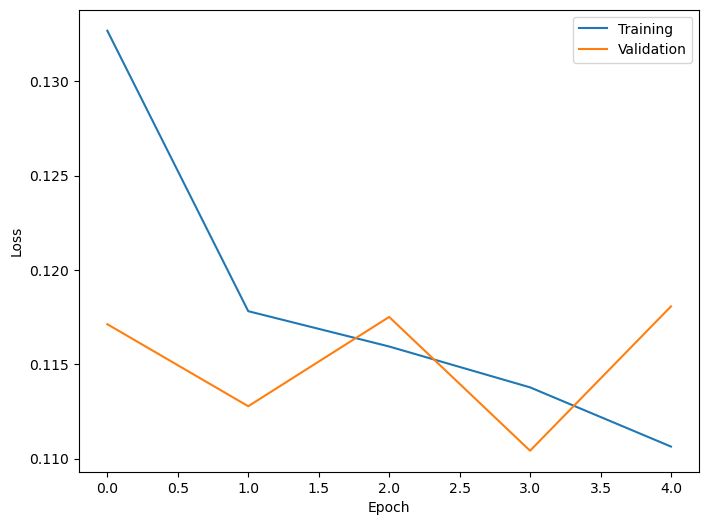

In [25]:
if epoch+1 == epochs:
    ep = epochs
else:
    ep = epoch
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(np.arange(ep), deit3_multi_train_losses, label="Training")
ax.plot(np.arange(ep), deit3_multi_val_losses, label="Validation")
ax.legend()
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")

## Swin V2

In [35]:
swin_multi = timm.create_model("swinv2_base_window16_256", pretrained = True)
num_classes = 2
#swin_multi.head = nn.Linear(swin_multi.head.in_features, num_classes)
swin_multi.reset_classifier(num_classes, global_pool='avg')

# Freeze all parameters first
for param in swin_multi.parameters():
    param.requires_grad = False

# Unfreeze the classification head
if hasattr(swin_multi, "head"):
    for param in swin_multi.head.parameters():
        param.requires_grad = True

# Unfreeze the last num_unfreeze transformer blocks
num_unfreeze = 3
if hasattr(swin_multi, "blocks"):
    for block in swin_multi.blocks[-num_unfreeze:]:
        for param in block.parameters():
            param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
swin_multi = swin_multi.to(device)

config = timm.data.resolve_model_data_config(swin_multi)

transform = transforms.Compose([
    transforms.Lambda(lambda img: img.squeeze(0) if img.shape[0] == 1 else img),
    transforms.ToPILImage(),
    transforms.Resize(config["input_size"][1:]),  # Resize to model's expected input size
    #transforms.Grayscale(num_output_channels=3),   # Convert grayscale to 3 channels
    transforms.ToTensor(),
    #transforms.Lambda(lambda x: torch.sinh(x)),
    transforms.Normalize(mean=config["mean"], std=config["std"])  # Use model-specific normalization
])

swin_multidata = DC.ClassificationDataset(datadir, labels, transform = transform)

In [37]:
train_size = int(0.81 * len(swin_multidata))
val_size = int(0.09*len(swin_multidata))
test_size = len(swin_multidata) - train_size - val_size
swin_multi_train_dataset, swin_multi_val_dataset, swin_multi_test_dataset = random_split(swin_multidata, [train_size, val_size, test_size])

batch_size = 256
num_workers = 4
prefetch_factor = 2
persistent_workers = True
swin_multi_train_loader = DataLoader(swin_multi_train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers,
                          pin_memory=True, persistent_workers=persistent_workers, prefetch_factor = prefetch_factor)
swin_multi_val_loader = DataLoader(swin_multi_val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers,
                        pin_memory=True, persistent_workers=persistent_workers, prefetch_factor = prefetch_factor)
swin_multi_test_loader = DataLoader(swin_multi_test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers,
                         pin_memory=True, persistent_workers=persistent_workers, prefetch_factor = prefetch_factor)

x,y = next(iter(swin_multi_train_loader))
print("x batch shape:", x.shape)  # Should be [batch_size, 3, 224, 224]
print("y batch shape:", y.shape)  # Should be [batch_size, 3]

x batch shape: torch.Size([256, 3, 256, 256])
y batch shape: torch.Size([256, 3])


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb8c4f102c0>
Traceback (most recent call last):
  File "/Software/users/modules/9/software/anaconda3/2024.02/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/Software/users/modules/9/software/anaconda3/2024.02/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/Software/users/modules/9/software/anaconda3/2024.02/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb8c4f102c0>
Traceback (most recent call last):
  File "/Software/users/modules/9/software/anaconda3/2024.02/lib/python3.11/site-package

In [38]:
criterion = nn.BCEWithLogitsLoss()
#optimizer = optim.Adam(swin_multi.parameters(), lr=0.005, weight_decay=1e-4)
optimizer = optim.AdamW(swin_multi.parameters(),
                        lr=1e-3,            # learning rate, adjust as needed
                        betas=(0.9, 0.999), # momentum parameters
                        eps=1e-8,           # term added to improve numerical stability
                        weight_decay=0.01)  # decoupled weight decay

In [39]:
epochs = 20
swin_multi_train_losses = []
swin_multi_val_losses = []

#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = epochs)

for epoch in range(epochs):
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}/{epochs} - Learning Rate: {current_lr:.6f}")

    train_loss = AF.training_epoch(swin_multi, swin_multi_train_loader, optimizer, criterion, device, unsqueezeY = False)
    val_loss = AF.evaluation_epoch(swin_multi, swin_multi_val_loader, criterion, device, desc = 'validation', unsqueezeY = False)

    # Step the scheduler
    #scheduler.step()

    print(f"Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

    swin_multi_train_losses.append(train_loss)
    swin_multi_val_losses.append(val_loss)

Epoch 1/20 - Learning Rate: 0.001000


Train Loss: 0.141958 | Val Loss: 0.115039
Epoch 2/20 - Learning Rate: 0.001000


Train Loss: 0.123127 | Val Loss: 0.113536
Epoch 3/20 - Learning Rate: 0.001000


Train Loss: 0.122167 | Val Loss: 0.112987
Epoch 4/20 - Learning Rate: 0.001000


Train Loss: 0.121253 | Val Loss: 0.112489
Epoch 5/20 - Learning Rate: 0.001000


Train Loss: 0.120533 | Val Loss: 0.111963
Epoch 6/20 - Learning Rate: 0.001000


Train Loss: 0.120321 | Val Loss: 0.111787
Epoch 7/20 - Learning Rate: 0.001000


Train Loss: 0.119779 | Val Loss: 0.111867
Epoch 8/20 - Learning Rate: 0.001000


Train Loss: 0.119656 | Val Loss: 0.111504
Epoch 9/20 - Learning Rate: 0.001000


Train Loss: 0.119590 | Val Loss: 0.111026
Epoch 10/20 - Learning Rate: 0.001000


Train Loss: 0.119264 | Val Loss: 0.111199
Epoch 11/20 - Learning Rate: 0.001000


Train Loss: 0.118805 | Val Loss: 0.110853
Epoch 12/20 - Learning Rate: 0.001000


Train Loss: 0.118643 | Val Loss: 0.110952
Epoch 13/20 - Learning Rate: 0.001000


Train Loss: 0.118638 | Val Loss: 0.110589
Epoch 14/20 - Learning Rate: 0.001000


Train Loss: 0.118110 | Val Loss: 0.110727
Epoch 15/20 - Learning Rate: 0.001000


Train Loss: 0.118313 | Val Loss: 0.110715
Epoch 16/20 - Learning Rate: 0.001000


Train Loss: 0.118133 | Val Loss: 0.111447
Epoch 17/20 - Learning Rate: 0.001000


Train Loss: 0.117929 | Val Loss: 0.110306
Epoch 18/20 - Learning Rate: 0.001000


Train Loss: 0.118067 | Val Loss: 0.110993
Epoch 19/20 - Learning Rate: 0.001000


Train Loss: 0.117708 | Val Loss: 0.109832
Epoch 20/20 - Learning Rate: 0.001000


Train Loss: 0.117736 | Val Loss: 0.109870


Text(0, 0.5, 'Loss')

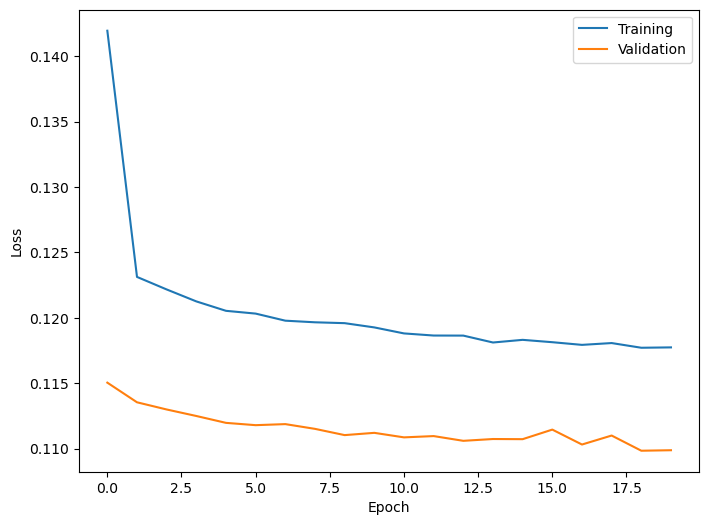

In [40]:
if epoch+1 == epochs:
    ep = epochs
else:
    ep = epoch
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(np.arange(ep), swin_multi_train_losses, label="Training")
ax.plot(np.arange(ep), swin_multi_val_losses, label="Validation")
ax.legend()
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")